<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20TMS%20XGboost%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# --- Google Colab Specific Setup ---
# Install necessary libraries if not already present
# Note: xgboost, optuna, scikit-learn are usually pre-installed in Colab
# If needed, uncomment the lines below:
# !pip install xgboost optuna scikit-learn pandas numpy matplotlib

# Upload the CSV file to Colab
from google.colab import files
import io

#print("Please upload 'raw_tms_timeseries_classification_arrays.csv'.")
#uploaded = files.upload()

# --- 1. Load and Prepare the Data ---
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv('tms_timeseries_clusters.csv', sep=',',decimal='.')

In [7]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 19.8 MB/s eta 0:00:00


In [34]:
df

,Unnamed: 0,patient_id,Avg_Resp_Left_Mean,Avg_Resp_Left_Std,Avg_Resp_Left_Hurst,Avg_Resp_Right_Mean,Avg_Resp_Right_Std,Avg_Resp_Right_Hurst,Avg_Resp_DTW_Cluster,Avg_Resp_DWT_Cluster,Inh_Thresh_DTW_Cluster,Inh_Thresh_DWT_Cluster,pain_type
0,0,patient_ 1n,53.259528,12.009135,0.397920,194.736574,40.132561,1.917325,0,1,3,1,2.0
1,1,patient_ 2n,123.597025,41.771269,1.163941,109.284255,41.218117,1.462129,1,1,1,1,2.0
2,2,patient_ 3n,39.701583,21.652062,1.099086,84.205208,32.102390,1.186651,3,0,1,1,2.0
3,3,patient_ 4n,73.540167,23.046395,0.802684,64.819444,13.978575,1.351294,1,0,1,1,2.0
4,4,patient_ 5n,100.746296,14.629567,0.809085,38.125000,10.383945,0.789748,1,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,56,patient_ 43,76.422778,22.373236,0.975436,66.449074,14.436201,1.486417,1,0,3,3,1.0
57,57,patient_ 44,83.317560,18.023992,1.785834,76.647917,28.206003,1.772336,1,0,0,0,0.0
58,58,patient_ 45,86.609226,24.699766,0.965192,61.637611,23.023425,1.693853,1,0,0,2,0.0
59,59,patient_ 46,98.417887,16.433997,0.459940,89.208167,25.067659,1.602354,3,0,2,2,1.0


In [41]:
df = df.drop(['Unnamed: 0','patient_id'], axis=1)

In [42]:
print("Original DataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# --- 2. Feature Engineering & Handling Missing Values ---
# Identify columns with missing values (NaN)
print("\nColumns with missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Define features (excluding non-numeric and identifier columns)
# We'll use the numeric columns representing responses and thresholds
feature_columns = df.columns


# Select the features
X = df[feature_columns].copy()

# Handle missing values (e.g., fill with median)
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True) # Or use mean, or drop rows

Original DataFrame shape: (61, 11)

First few rows:
   Avg_Resp_Left_Mean  Avg_Resp_Left_Std  Avg_Resp_Left_Hurst  \
0           53.259528          12.009135             0.397920   
1          123.597025          41.771269             1.163941   
2           39.701583          21.652062             1.099086   
3           73.540167          23.046395             0.802684   
4          100.746296          14.629567             0.809085   

   Avg_Resp_Right_Mean  Avg_Resp_Right_Std  Avg_Resp_Right_Hurst  \
0           194.736574           40.132561              1.917325   
1           109.284255           41.218117              1.462129   
2            84.205208           32.102390              1.186651   
3            64.819444           13.978575              1.351294   
4            38.125000           10.383945              0.789748   

   Avg_Resp_DTW_Cluster  Avg_Resp_DWT_Cluster  Inh_Thresh_DTW_Cluster  \
0                     0                     1                       3   
1 

[I 2025-12-18 20:35:29,623] A new study created in memory with name: no-name-af04941b-2dd0-4329-9c9b-475102a93d8d



Target distribution (threshold at 1.00):
pain_type
0    32
1    29
Name: count, dtype: int64

Training set shape: (48, 11)
Test set shape: (13, 11)
Starting Optuna optimization...


[I 2025-12-18 20:35:30,216] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.1263134746453049, 'max_depth': 5, 'min_child_weight': 1.6110659624637487, 'gamma': 0.48352428130395086, 'subsample': 0.6896406866291261, 'colsample_bytree': 0.8315942930364635, 'reg_alpha': 1.0938127208245054, 'reg_lambda': 0.6505383254729418, 'n_estimators': 550}. Best is trial 0 with value: 1.0.
[I 2025-12-18 20:35:30,634] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.039336775230792806, 'max_depth': 9, 'min_child_weight': 3.0608831933825664, 'gamma': 0.5725484562097782, 'subsample': 0.7247392615780631, 'colsample_bytree': 0.9374329109378385, 'reg_alpha': 0.8541821134962737, 'reg_lambda': 0.6926627243231623, 'n_estimators': 300}. Best is trial 0 with value: 1.0.
[I 2025-12-18 20:35:31,434] Trial 2 finished with value: 0.8 and parameters: {'learning_rate': 0.02206254210333107, 'max_depth': 6, 'min_child_weight': 4.491173695694629, 'gamma': 1.826801979492921, 'subsamp

Optimization finished.
Best ROC-AUC score: 1.0
Best parameters: {'learning_rate': 0.1263134746453049, 'max_depth': 5, 'min_child_weight': 1.6110659624637487, 'gamma': 0.48352428130395086, 'subsample': 0.6896406866291261, 'colsample_bytree': 0.8315942930364635, 'reg_alpha': 1.0938127208245054, 'reg_lambda': 0.6505383254729418, 'n_estimators': 550}

--- Final Model Evaluation ---
Test Accuracy: 1.0000
Test ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

 Low Response       1.00      1.00      1.00         7
High Response       1.00      1.00      1.00         6

     accuracy                           1.00        13
    macro avg       1.00      1.00      1.00        13
 weighted avg       1.00      1.00      1.00        13



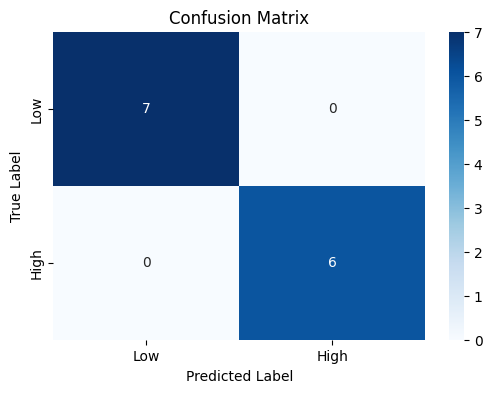

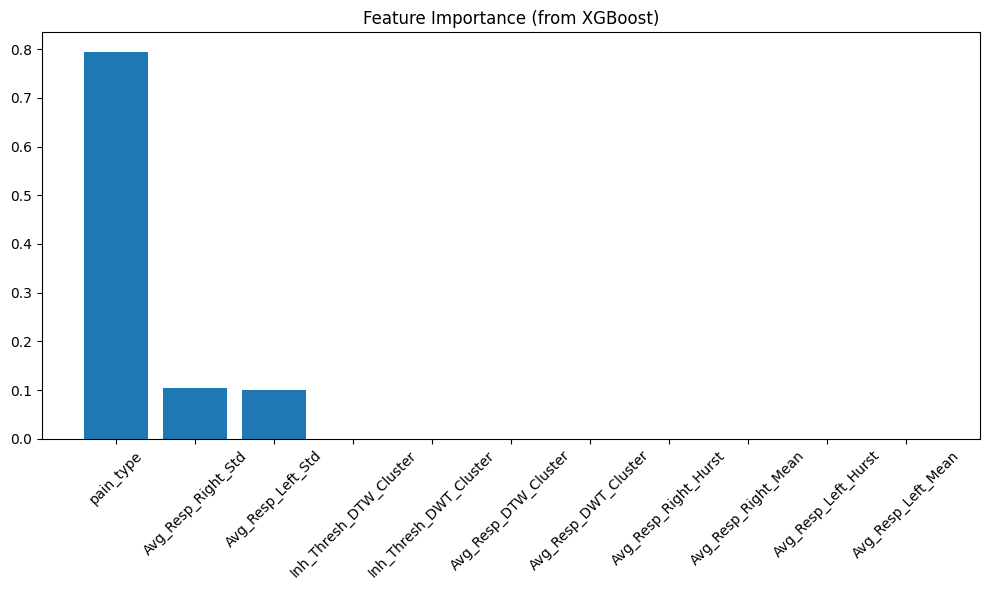

In [43]:



# --- 3. Create a Target Variable (Example) ---
# Since the original 'label' (bird/mammal) is missing, we need to create one.
# Let's create a simple binary label based on 'avg_respone_right' (e.g., high vs low response)
# You can modify this logic based on your specific research question.
threshold = X['pain_type'].median() # Example: use median as split
y = (X['pain_type'] > threshold).astype(int) # 1 if high, 0 if low

# Optional: Drop the column used for label creation from features if it's not a predictor
# X = X.drop(columns=['avg_respone_right'])

print(f"\nTarget distribution (threshold at {threshold:.2f}):")
print(y.value_counts())

# --- 4. Prepare Data for Modeling ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler # Often beneficial for tree methods too

# Optional: Standardize features (can be helpful for some algorithms, though less critical for tree-based ones)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Keep column names

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y # Stratify to maintain label ratio
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# --- 5. Optuna Hyperparameter Optimization for XGBoost ---
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score

def objective(trial):
    # Define the parameter space for XGBoost
    params = {
        "objective": "binary:logistic", # For binary classification
        "tree_method": "hist", # Efficient for medium datasets
        "max_bin": 256, # Speed up training
        "random_state": 42, # For reproducibility

        # Hyperparameters to optimize
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 2.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
    }

    # Use cross-validation to evaluate parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        # Removed early_stopping_rounds as it's not directly supported in fit() anymore
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        y_pred_proba = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred_proba)
        cv_scores.append(score)

    mean_score = np.mean(cv_scores)
    return mean_score # Optuna maximizes, so return the score directly

# --- 6. Run Optuna Optimization ---
study = optuna.create_study(direction="maximize")
print("Starting Optuna optimization...")
study.optimize(objective, n_trials=50) # Reduce trials for demo speed

print("Optimization finished.")
print("Best ROC-AUC score:", study.best_value)
print("Best parameters:", study.best_params)

# --- 7. Train Final Model and Evaluate ---
best_params = study.best_params.copy()
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Final Model Evaluation ---")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")

# Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Response', 'High Response']))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance Plot
importances = best_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (from XGBoost)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()